In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import sympy as sp
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt

import aurel
from aurel.solutions import Collins_Stewart as sol
#from aurel.solutions import Conformally_flat as sol
#from aurel.solutions import Harvey_Tsoubelis as sol
#from aurel.solutions import Non_diagonal as sol
#from aurel.solutions import Rosquist_Jantzen as sol
#from aurel.solutions import Schwarzschild as sol #too long for analytics
#from aurel.solutions import Szekeres as sol #too long for analytics

In [2]:
#Analytical setup
t, x, y, z = sp.symbols('t x y z')

# Spacetime
g = sol.gdown4(t, x, y, z, analytical=True)
an4 = aurel.AurelCoreAnalytic([t, x, y, z], g)

# Space
gamma = sol.gammadown3(t, x, y, z, analytical=True)
an3 = aurel.AurelCoreAnalytic([x, y, z], gamma)

In [3]:
# Numerical setup

L = 20
N = 64
grid = {
    'Nx': N,  # Number of data points per side
    'Ny': N,
    'Nz': N,
    'xmin': - L / 2 + 0.01,  # Minimum x coordinate
    'ymin': - L / 2 + 0.01,  # Minimum y coordinate
    'zmin': - L / 2 + 0.01,  # Minimum z coordinate
    'dx': L / N,  # Elementary grid size
    'dy': L / N,
    'dz': L / N,
}
fd = aurel.FiniteDifference(grid, boundary='other', fd_order=8)
rel = aurel.AurelCore(fd)

nt = 1
nx, ny, nz = fd.cartesian_coords

rel.data = sol.data(nt, nx, ny, nz)
rel.freeze_data()

8th order finite difference schemes are defined


<IPython.core.display.Latex object>

In [4]:
err_max = 1e-4

custom_funcs = {
    "hyper": lambda a, b, z: sc.hyp2f1(a[0], a[1], b[0], z),
    "exp_polar": np.exp}
def compare_values(theory, numerical):
    f_num = sp.lambdify((t, x, y, z), theory, modules=[custom_funcs, "numpy"])
    s1 = np.real(f_num(nt, fd.cutoffmask(nx), fd.cutoffmask(ny), fd.cutoffmask(nz)))
    s2 = fd.cutoffmask(numerical)
    if theory != 0:
        rel_err = np.abs(aurel.maths.safe_division(s2 - s1, s1))
        error = np.max(np.ma.masked_invalid(rel_err))
    else:
        error = np.max(np.abs(s2))
    return error

def checks(var, theory, numerical):
    error = compare_values(theory, numerical)
    if error > err_max:
        print(var, 
              f", max(abs(num_val)) = ", np.max(abs(fd.cutoffmask(numerical))), 
              ", relative error =", error)

def check1d(dim, var, theory, numerical):
    for i in range(dim):
        checks(var+f"{i}", theory[i], numerical[i])

def check2d(dim, var, theory, numerical):
    for i in range(dim):
        for j in range(dim):
            checks(var+f"{i}{j}", theory[i, j], numerical[i, j])

def check3d(dim, var, theory, numerical):
    for i in range(dim):
        for j in range(dim):
            for k in range(dim):
                checks(var+f"{i}{j}{k}", theory[i, j, k], numerical[i, j, k])
def check4d(dim, var, theory, numerical):
    for i in range(dim):
        for j in range(dim):
            for k in range(dim):
                for l in range(dim):
                    checks(var+f"{i}{j}{k}{l}", theory[i, j, k, l], numerical[i, j, k, l])

def plot_them(analytical, numerical, cutoff=True):
    f_num = sp.lambdify((t, x, y, z), analytical, modules=[custom_funcs, "numpy"])
    A = np.real(f_num(nt, nx, ny, nz))
    if isinstance(A, int) or isinstance(A, float):
        A = np.full_like(numerical, A)

    rel_error = np.abs(aurel.maths.safe_division(numerical - A, A))
    ix, iy, iz = np.where(rel_error == np.max(rel_error))
    if len(ix) > 1:
        ix = ix[0]
        iy = iy[0]
        iz = iz[0]
    print("max {:.2e} error at".format(np.max(rel_error)), ix, iy, iz)
    if iy < 2*fd.mask_len or iz < 2*fd.mask_len:
        cutoff = False
        print('Max relative difference in boundary region')

    if cutoff:
        xv = fd.cutoffmask(fd.xarray)
        nv = fd.cutoffmask(numerical[:,iy,iz])
        av = fd.cutoffmask(A[:,iy,iz])
        rv = fd.cutoffmask(rel_error[:,iy,iz])
    else:
        xv = fd.xarray
        nv = numerical[:,iy,iz]
        av = A[:,iy,iz]
        rv = rel_error[:,iy,iz]

    plt.figure()
    plt.subplot(211)
    plt.plot(xv, nv, 
             label="numerical")
    plt.plot(xv, av, 
             linestyle='--',
             label="analytical")
    plt.grid()
    plt.legend()
    plt.subplot(212)
    plt.semilogy(xv, rv)
    plt.grid()
    plt.ylabel("relative difference")
    plt.xlabel("x")
    plt.subplots_adjust(hspace=0.0)

# Check Christoffel symbols

## 3D

In [5]:
check2d(3, "gamma^", an3["gup"], rel["gammaup3"])

check3d(3, "Γudd", an3["Gamma_udd"], rel["s_Gamma_udd3"])

Calculated analytic gup: Metric tensor in the up index form


<IPython.core.display.Latex object>

Calculated analytic Gamma_udd: Christoffel symbols in the up-down-down index form


<IPython.core.display.Latex object>

## 4D

In [6]:
check2d(4, "g^", an4["gup"], rel["gup4"])
check3d(4, "Γudd", an4["Gamma_udd"], rel["st_Gamma_udd4"])

Calculated analytic gup: Metric tensor in the up index form


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Calculated analytic Gamma_udd: Christoffel symbols in the up-down-down index form


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Check Riemann and Ricci

## 3D

In [7]:
# Compute 3-Riemann tensor: R^i_{jkl}
check4d(3, "Ruddd", an3["Riemann_uddd"], rel["s_Riemann_uddd3"])

0 1 0 1,  0 1 0 2,  0 1 1 2,  0 2 0 1,  0 2 0 2,  0 2 1 2,  1 0 0 1,  1 0 0 2,  1 0 1 2,  1 2 0 1,  1 2 0 2,  1 2 1 2,  2 0 0 1,  2 0 0 2,  2 0 1 2,  2 1 0 1,  2 1 0 2,  2 1 1 2,  
Calculated analytic Riemann_uddd: Riemann curvature tensor in the up-down-down-down index form


<IPython.core.display.Latex object>

Ruddd0001 , max(abs(num_val)) =  0.17739989130649478 , relative error = 0.17739989130649478
Ruddd0010 , max(abs(num_val)) =  0.17739989130649478 , relative error = 0.17739989130649478
Ruddd1101 , max(abs(num_val)) =  0.17739989130649472 , relative error = 0.17739989130649472
Ruddd1110 , max(abs(num_val)) =  0.17739989130649475 , relative error = 0.17739989130649475


In [8]:
# Lower the first index: R_{lijk} = γ_{lm} R^m_{ijk}
check4d(3, "R_", an3["Riemann_down"], rel["s_Riemann_down3"])

0 1 0 1,  0 1 0 2,  0 1 1 2,  0 2 0 2,  0 2 1 2,  1 2 1 2,  
Calculated analytic Riemann_down: Riemann curvature tensor in the down index form


<IPython.core.display.Latex object>

R_0101 , max(abs(num_val)) =  0.04687500000004048 , relative error = 0.9347372439864493
R_0110 , max(abs(num_val)) =  0.046875000000040586 , relative error = 0.9347372439864492
R_1001 , max(abs(num_val)) =  0.04687500000004078 , relative error = 0.9347372439864493
R_1010 , max(abs(num_val)) =  0.04687500000004078 , relative error = 0.9347372439864493


In [9]:
check2d(3, "R_", an3["Ricci_down"], rel["s_Ricci_down3"])

Calculated analytic Ricci_down: Ricci curvature tensor in the down index form


<IPython.core.display.Latex object>

R_01 , max(abs(num_val)) =  0.3547997826129471 , relative error = 1.0000000000008402
R_10 , max(abs(num_val)) =  0.3547997826129469 , relative error = 1.0000000000008409


In [10]:
checks("R", an3["RicciS"], rel["s_RicciS"])

Calculated analytic RicciS: Ricci scalar


<IPython.core.display.Latex object>

R , max(abs(num_val)) =  0.09375000000087907 , relative error = 9.575147577011371


max 9.58e+00 error at [63] [1] [39]
Max relative difference in boundary region


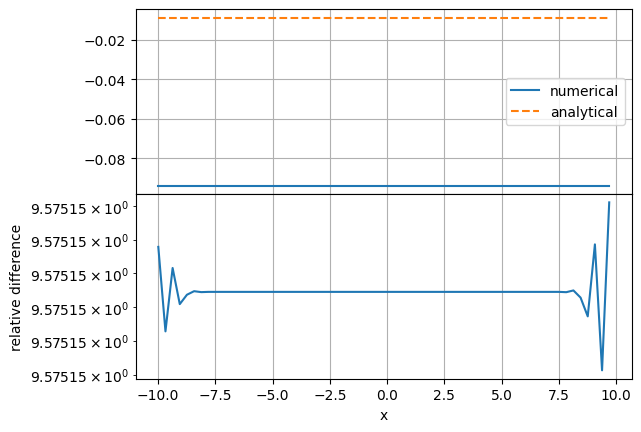

In [11]:
plot_them(an3["RicciS"], rel["s_RicciS"])

## 4D

In [12]:
check4d(4, "Ruddd", an4["Riemann_uddd"], rel["st_Riemann_uddd4"])

0 1 0 1,  0 1 0 2,  0 1 0 3,  0 1 1 2,  0 1 1 3,  0 1 2 3,  0 2 0 1,  0 2 0 2,  0 2 0 3,  0 2 1 2,  0 2 1 3,  0 2 2 3,  0 3 0 1,  0 3 0 2,  0 3 0 3,  0 3 1 2,  0 3 1 3,  0 3 2 3,  1 0 0 1,  1 0 0 2,  1 0 0 3,  1 0 1 2,  1 0 1 3,  1 0 2 3,  1 2 0 1,  1 2 0 2,  1 2 0 3,  1 2 1 2,  1 2 1 3,  1 2 2 3,  1 3 0 1,  1 3 0 2,  1 3 0 3,  1 3 1 2,  1 3 1 3,  1 3 2 3,  2 0 0 1,  2 0 0 2,  2 0 0 3,  2 0 1 2,  2 0 1 3,  2 0 2 3,  2 1 0 1,  2 1 0 2,  2 1 0 3,  2 1 1 2,  2 1 1 3,  2 1 2 3,  2 3 0 1,  2 3 0 2,  2 3 0 3,  2 3 1 2,  2 3 1 3,  2 3 2 3,  3 0 0 1,  3 0 0 2,  3 0 0 3,  3 0 1 2,  3 0 1 3,  3 0 2 3,  3 1 0 1,  3 1 0 2,  3 1 0 3,  3 1 1 2,  3 1 1 3,  3 1 2 3,  3 2 0 1,  3 2 0 2,  3 2 0 3,  3 2 1 2,  3 2 1 3,  3 2 2 3,  
Calculated analytic Riemann_uddd: Riemann curvature tensor in the up-down-down-down index form


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Ruddd1103 , max(abs(num_val)) =  0.30726562500000076 , relative error = 0.30726562500000076
Ruddd1112 , max(abs(num_val)) =  0.7687328623280572 , relative error = 0.7687328623280572
Ruddd1121 , max(abs(num_val)) =  0.7687328623280567 , relative error = 0.7687328623280567
Ruddd1130 , max(abs(num_val)) =  0.30726562500000076 , relative error = 0.30726562500000076
Ruddd2203 , max(abs(num_val)) =  0.30726562500000076 , relative error = 0.30726562500000076
Ruddd2212 , max(abs(num_val)) =  0.7687328623280572 , relative error = 0.7687328623280572
Ruddd2221 , max(abs(num_val)) =  0.7687328623280572 , relative error = 0.7687328623280572
Ruddd2230 , max(abs(num_val)) =  0.30726562500000076 , relative error = 0.30726562500000076


In [13]:
check4d(4, "R_", an4["Riemann_down"], rel["st_Riemann_down4"])

0 1 0 1,  0 1 0 2,  0 1 0 3,  0 1 1 2,  0 1 1 3,  0 1 2 3,  0 2 0 2,  0 2 0 3,  0 2 1 2,  0 2 1 3,  0 2 2 3,  0 3 0 3,  0 3 1 2,  0 3 1 3,  0 3 2 3,  1 2 1 2,  1 2 1 3,  1 2 2 3,  1 3 1 3,  1 3 2 3,  2 3 2 3,  
Calculated analytic Riemann_down: Riemann curvature tensor in the down index form
R_1212 , max(abs(num_val)) =  0.20312500000004052 , relative error = 0.934737243986446
R_1221 , max(abs(num_val)) =  0.20312500000004063 , relative error = 0.934737243986446
R_2112 , max(abs(num_val)) =  0.20312500000004075 , relative error = 0.934737243986446
R_2121 , max(abs(num_val)) =  0.20312500000004075 , relative error = 0.934737243986446


max 9.49e-01 error at [62] [1] [0]
Max relative difference in boundary region


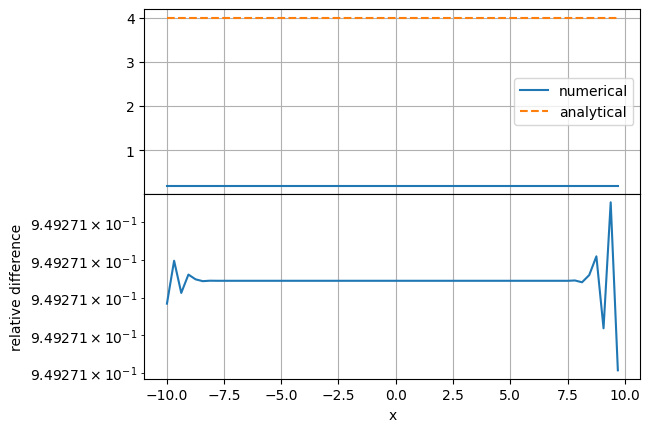

In [14]:
plot_them(an4["Riemann_down"][2,1,2,1], rel["st_Riemann_down4"][2,1,2,1])

In [15]:
check2d(4, "R_", an4["Ricci_down"], rel["st_Ricci_down4"])

Calculated analytic Ricci_down: Ricci curvature tensor in the down index form


<IPython.core.display.Latex object>

R_03 , max(abs(num_val)) =  0.0 , relative error = 1.0
R_12 , max(abs(num_val)) =  0.8278661594301866 , relative error = 13.000000000000188
R_21 , max(abs(num_val)) =  0.8278661594301866 , relative error = 13.000000000000188
R_30 , max(abs(num_val)) =  0.0 , relative error = 1.0


In [16]:
checks("R", an4["RicciS"], rel["st_RicciS"])

Calculated analytic RicciS: Ricci scalar


<IPython.core.display.Latex object>

R , max(abs(num_val)) =  1.5265566588595902e-15 , relative error = 1.000000000000021
